<a href="https://colab.research.google.com/github/Nandini1230/CodeClauseInternship_Credit-Card-Fraud-Detection/blob/main/credit_card_fraud_detection_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection with TensorFlow
- The credit card dataset contains transaction data used for fraud detection. It includes features like time, transaction amount, and anonymized features (V1-V28).
- The dataset has imbalanced classes, with mostly legitimate transactions (Class 0) and fewer fraudulent ones (Class 1).
- My goal is to build a model that accurately classify transactions as fraudulent or legitimate, using techniques like regularization and evaluation metrics such as precision, recall, and F1-score.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import regularizers
from scipy.stats import ks_2samp
# load data
data = pd.read_csv("creditcard.csv")
X = data.drop('Class', axis=1).values
y = data['Class'].values

# plot the class distribution
pd.value_counts(data['Class'])

0    284315
1       492
Name: Class, dtype: int64

# Distribution of credit card transactions over time

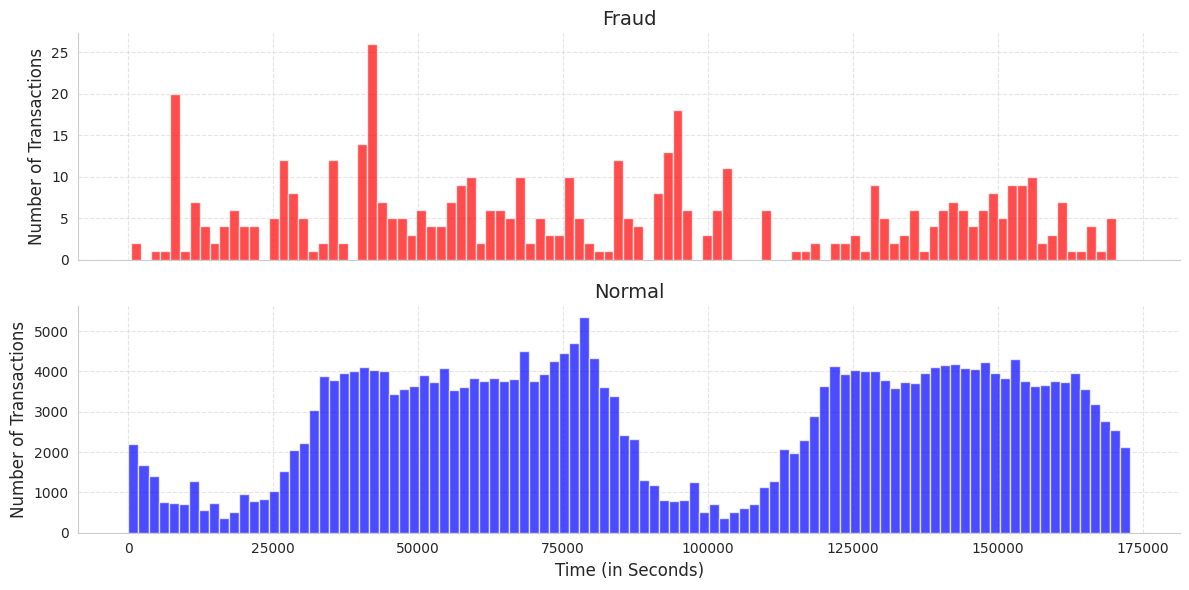

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

bins = 100

# Plotting for Fraud transactions
ax1.hist(data.Time[data.Class == 1], bins=bins, color='red', alpha=0.7)
ax1.set_title('Fraud', fontsize=14)
ax1.set_ylabel('Number of Transactions', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# Plotting for Normal transactions
ax2.hist(data.Time[data.Class == 0], bins=bins, color='blue', alpha=0.7)
ax2.set_title('Normal', fontsize=14)
ax2.set_xlabel('Time (in Seconds)', fontsize=12)
ax2.set_ylabel('Number of Transactions', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

The red histogram represents fraudulent transactions. The x-axis shows the time in seconds, and the y-axis represents the number of transactions. Fraudulent transactions are relatively infrequent compared to normal transactions, as seen by the lower y-axis values. There are peaks at certain times, suggesting that fraudulent activity may occur in bursts or at specific moments rather than evenly distributed throughout the time frame covered.

The blue histogram represents normal transactions which have a higher volume. The pattern here is more consistent, with what appears to be a cyclical pattern suggesting higher transaction volumes at regular intervals. This could correspond to peak transaction times during the day, such as morning and evening hours when people are more likely to use their credit cards.

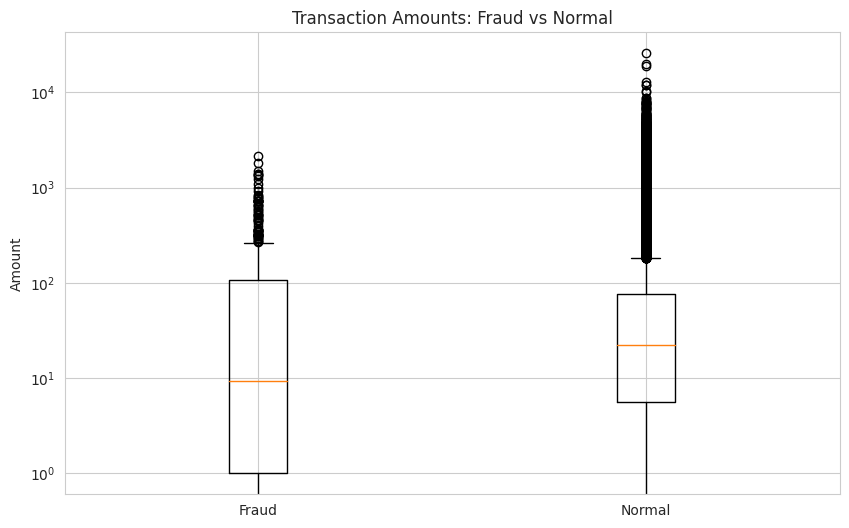

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([data[data["Class"]==1]["Amount"], data[data["Class"]==0]["Amount"]],
            labels=['Fraud', 'Normal'])

plt.title('Transaction Amounts: Fraud vs Normal')
plt.ylabel('Amount')
plt.yscale('log')
plt.show()

The median fraudulent transaction is of **9.25** with the largest amount in a fraudulent transaction being **2125.87**.
The median amount for a normal transaction is **22** whereas the largest amount is **25691** which is substantially higher than the maximum for a fraudulent transaction. This could be due to the larger sample size or it could indicate that fraudsters avoid extremely large transactions that might trigger security mechanisms.

# Data Preparation
- Split data into training, validation, and test sets (60/20/20).
- Use stratified sampling to maintain the class distribution in each split.
- Scale the training, validation, and test sets to a mean of zero mean and unit variance.

In [ ]:
# split data into train, validation, and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Model Architecture

In [ ]:
model = tf.keras.Sequential(
    [
        # Adjusted number of neurons
        tf.keras.layers.Dense(128, activation="relu", input_shape=(X.shape[-1],),
                              kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
        tf.keras.layers.Dropout(0.2),  # Adjusted dropout rate
        tf.keras.layers.Dense(64, activation="relu",
                              kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
        tf.keras.layers.Dropout(0.2),  # Adjusted dropout rate
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1. Input Layer: A dense layer with 128 neurons, ReLU activation function, and L2 regularization with a strength of 0.001. It takes input data with a shape determined by the number of features in the dataset.
2. Dropout Layer: A dropout layer with a dropout rate of 0.2, which helps prevent overfitting by randomly deactivating 20% of neurons during training.
3. Hidden Layer: Another dense layer with 64 neurons, ReLU activation, and L2 regularization with a strength of 0.001.
4. Another Dropout Layer: Similar to the previous dropout layer, with a rate of 0.2.
5. Output Layer: A dense layer with a single neuron and sigmoid activation function, used for binary classification.

### ReLU activation function
- Decides whether the neuron should be activated or not.
- Introduces non-linear transformation making it capable to learn and perform more complex tasks.


### Regularization
These are the most common regularization techniques.

- During the model definition I introduced parameter regularization (weight decay) and neural network regularization (dropout).
- During the model training I added early stopping.

#### Weight decay

Weight decay is a regularization term implemented from tensorflow.keras with the following formula:


`math_ops.reduce_sum(math_ops.square(x))` calculates the sum of the squares of all elements in the tensor x

#### Dropout regularization
- Deep neural nets with a large number of parameters are powerful but prone to overfitting.
- Dropout is a technique for addressing this problem. The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much.
- During training, dropout samples form an exponential number of different “thinned” networks. At test time, instead of using all these thinned networks, we can approximate their effect by using a single unthinned network with smaller weights.

# Metrics

In [ ]:
metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

In this imbalanced dataset using accuracy as the evaluation metric is not appropriate because it can be misleading. A model that predicts all instances as negative 0 would still achieve a high accuracy of 99%, even though it's not providing meaningful results. This is why I am prioritizing the following metrics:



- `Precision` calculates the ratio of true positives to the total number of positive predictions (true positives + false positives).

- `Recall` calculates the ratio of true positives to the total number of actual positive instances (true positives + false negatives).

# Model training
- Use the Adam optimizer with a learning rate of 0.0001.
- Utilize binary cross-entropy as the loss function.
- Set up an early stopping callback that monitors the validation loss for minimization.
- Specify a patience of 5 epochs before stopping training if the validation loss does not improve.
- Set class weights such that class 0 has a weight of 1, and class 1 has a weight of 5, giving more importance to the minority class.
- Train for a maximum of 100 epochs.

In [ ]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = metrics)

# configure early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# calculate class weights
neg, pos = np.bincount(y_train)
total = neg + pos
class_weight = {0: 1, 1: 5}

# train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[es], class_weight=class_weight)

Epoch 1/50
4006/4006 [==============================] - 26s 6ms/step - loss: 0.1670 - fn: 125.0000 - fp: 63.0000 - tn: 127879.0000 - tp: 96.0000 - precision: 0.6038 - recall: 0.4344 - val_loss: 0.0967 - val_fn: 17.0000 - val_fp: 15.0000 - val_tn: 42632.0000 - val_tp: 57.0000 - val_precision: 0.7917 - val_recall: 0.7703
Epoch 2/50
4006/4006 [==============================] - 20s 5ms/step - loss: 0.0883 - fn: 53.0000 - fp: 25.0000 - tn: 127917.0000 - tp: 168.0000 - precision: 0.8705 - recall: 0.7602 - val_loss: 0.0622 - val_fn: 13.0000 - val_fp: 14.0000 - val_tn: 42633.0000 - val_tp: 61.0000 - val_precision: 0.8133 - val_recall: 0.8243
Epoch 3/50
4006/4006 [==============================] - 21s 5ms/step - loss: 0.0558 - fn: 47.0000 - fp: 27.0000 - tn: 127915.0000 - tp: 174.0000 - precision: 0.8657 - recall: 0.7873 - val_loss: 0.0378 - val_fn: 11.0000 - val_fp: 14.0000 - val_tn: 42633.0000 - val_tp: 63.0000 - val_precision: 0.8182 - val_recall: 0.8514
Epoch 4/50
4006/4006 [===============

# Model Evaluation and Loss Visualization
- Use the trained model to make predictions on the test dataset.
- Calculate precision, recall, and F1 score as evaluation metrics for the model's performance on the test data.
- Visualize the training and validation loss over the training epochs.

3561/3561 [==============================] - 1s 259us/step

Precision: 0.75

Recall: 0.8223350253807107

F1 Score: 0.784503631961259


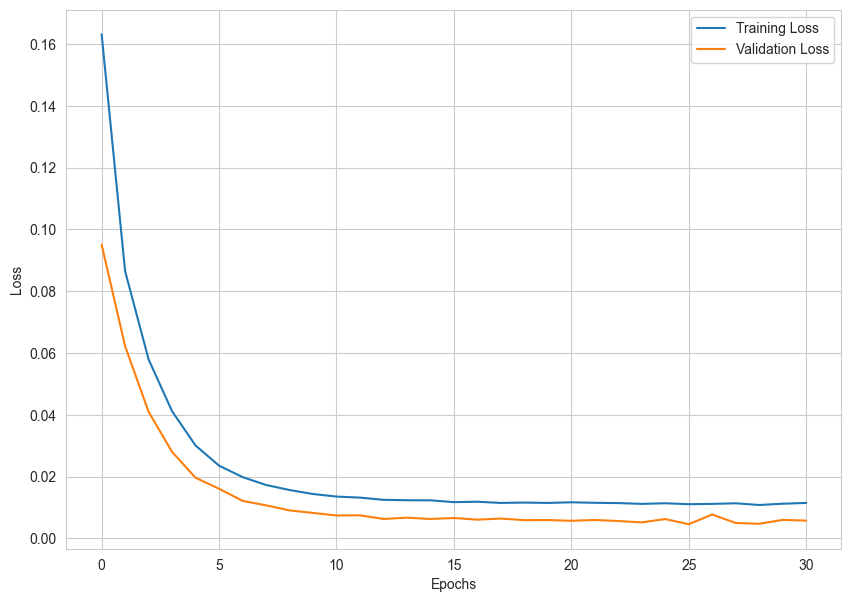

In [ ]:
# predict test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# score precision, recall, and f1
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot only the losses from history
losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 7))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

- The training Loss decreases sharply at the beginning, which indicates that the model is quickly learning from the training data. As epochs increase, the rate of decrease slows down, suggesting that the model is starting to converge and is learning less from the training data with each epoch.
- The validation Loss decreases along with the training loss, but it starts to plateau toward the end. The fact that the validation loss levels off but does not increase indicates that the model is not overfitting.
- The early stopping after 30 epochs suggests that the model reached an optimal state in terms of generalization before performance on the validation set could deteriorate.